In [1]:
!pip install pyLDAvis
!pip install sentence-transformers scipy

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.6/2.6 MB 39.9 MB/s eta 0:00:00


In [3]:
# Download NLTK packages
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt')
nltk.download('punkt_tab')

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


True

In [2]:
import matplotlib.pyplot as plt
import nltk
import numpy as np
import pandas as pd
import pyLDAvis.gensim
import re
import seaborn as sns

from gensim.models import CoherenceModel
from gensim.corpora.dictionary import Dictionary
from gensim.models import LdaModel
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sentence_transformers import SentenceTransformer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import jaccard_score
from sklearn.metrics.pairwise import cosine_similarity

from google.colab import drive

/usr/local/lib/python3.10/dist-packages/sentence_transformers/cross_encoder/CrossEncoder.py:13: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm, trange
/usr/local/lib/python3.10/dist-packages/tensorflow/lite/python/util.py:55: DeprecationWarning: jax.xla_computation is deprecated. Please use the AOT APIs; see https://jax.readthedocs.io/en/latest/aot.html. For example, replace xla_computation(f)(*xs) with jit(f).lower(*xs).compiler_ir('hlo'). See CHANGELOG.md for 0.4.30 for more examples.
  from jax import xla_computation as _xla_computation
/usr/local/lib/python3.10/dist-packages/tensorflow/lite/python/util.py:55: DeprecationWarning: jax.xla_computation is deprecated. Please use the AOT APIs; see https://jax.readthedocs.io/en/latest/aot.html. For example, replace xla_computation(f)(*xs) with jit(f).lower(*xs).compiler_ir('hlo'). See CHANGELOG.md for 0.4

In [7]:
drive.mount('/content/drive')

data = pd.read_excel('/content/drive/MyDrive/Manufactured Ecosystems/fuel/fuel.xlsx')
data = pd.DataFrame(data)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Preprocessing

Feature Engineering, combine suitability and confidence score as composite score where high score means high suitablity **AND** high confidence level. Low score means low suitability **OR** low confidence level.

In [8]:
import pandas as pd
# Map Suitability Labels to Numerical Values
label_to_value = {"yes": 0.9, "maybe": 0.5, "no": 0.2}
data["Suitability"] = data["Suitability"].map(label_to_value)

# Compute Composite Score
data["Composite Score"] = data["Suitability"] * data["Confidence"]

# Output the DataFrame
print(data.head(5))

   Index    Authors                                      Article Title  \
0     12        Lal        Soils and food sufficiency. A review et al.   
1     34  Ostergard  Time for a shift in crop production: embracing...   
2     46   Tripathi  Biotechnological Advances for Restoring Degrad...   
3      2     Pretty  Sustainable intensification in agricultural sy...   
4     17      Smith  Reconciling productivity with protection of th...   

   Unnamed: 3  Publication Year  \
0         NaN              2009   
1         NaN              2009   
2         NaN              2017   
3         NaN              2014   
4         NaN              2013   

                                            Abstract  Suitability  Confidence  \
0  Soil degradation, caused by land misuse and so...          0.9        0.75   
1  A radical shift in our approach to crop produc...          0.9        0.70   
2  Global land resources are under severe threat ...          0.9        0.75   
3  Background Agricu

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [9]:
# Preprocessing function
def preprocess_text(text):
    stop_words = set(stopwords.words('english'))
    lemmatizer = WordNetLemmatizer()

    # Lowercase, remove special characters
    text = re.sub(r'[^\w\s]', '', text.lower())

    # Tokenize
    words = nltk.word_tokenize(text)

    # Remove stopwords and lemmatize
    processed = [lemmatizer.lemmatize(word) for word in words if word not in stop_words]
    return processed

# Load abstracts
abstracts = data['Abstract']
keywords = data['Keyword']
# Preprocess all abstracts
preprocessed_abstracts = [preprocess_text(abstract) for abstract in abstracts]
preprocessed_keywords = [preprocess_text(keyword) for keyword in keywords]

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


# LDA

## Optimal Topic Number

In [10]:
# Create a dictionary representation of the documents
dictionary = Dictionary(preprocessed_abstracts)

# Convert the documents into a bag-of-words format
corpus = [dictionary.doc2bow(text) for text in preprocessed_abstracts]

print("Sample BOW representation:", corpus[:1])  # Example output

Sample BOW representation: [[(0, 1), (1, 1), (2, 1), (3, 1), (4, 1), (5, 1), (6, 1), (7, 3), (8, 1), (9, 1), (10, 1), (11, 1), (12, 1), (13, 1), (14, 1), (15, 1), (16, 1), (17, 1), (18, 1), (19, 1), (20, 1), (21, 1), (22, 1), (23, 1), (24, 2), (25, 1), (26, 2), (27, 1), (28, 1), (29, 1), (30, 1), (31, 1), (32, 1), (33, 1), (34, 1), (35, 5), (36, 1), (37, 1), (38, 3), (39, 1), (40, 2), (41, 1), (42, 1), (43, 3), (44, 2), (45, 1), (46, 2), (47, 1), (48, 1), (49, 2), (50, 2), (51, 1), (52, 2), (53, 1), (54, 1), (55, 1), (56, 1), (57, 1), (58, 2), (59, 1), (60, 3), (61, 1), (62, 2), (63, 1), (64, 1), (65, 2), (66, 1), (67, 1), (68, 1), (69, 2), (70, 1), (71, 1), (72, 1), (73, 1), (74, 1), (75, 1), (76, 1), (77, 3), (78, 1), (79, 1), (80, 1), (81, 1), (82, 1), (83, 1), (84, 1), (85, 1), (86, 3), (87, 3), (88, 1), (89, 1), (90, 1), (91, 1), (92, 1), (93, 1), (94, 1), (95, 1), (96, 2), (97, 1), (98, 3), (99, 1), (100, 1), (101, 3), (102, 1), (103, 1), (104, 1), (105, 1), (106, 1), (107, 1), (

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


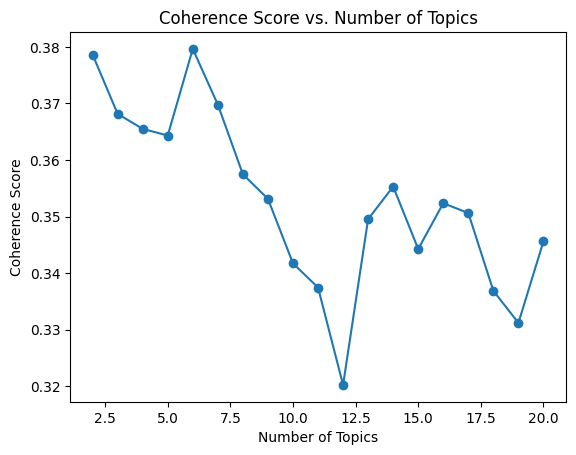

In [11]:
# Function to compute coherence scores for different topic numbers
def find_optimal_topics(corpus, dictionary, texts, start=2, end=20):
    coherence_scores = []
    for num_topics in range(start, end + 1):
        lda_model = LdaModel(corpus, num_topics=num_topics, id2word=dictionary, passes=15, random_state=42)
        coherence_model = CoherenceModel(model=lda_model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_scores.append((num_topics, coherence_model.get_coherence()))
    return coherence_scores

# Compute coherence scores
coherence_scores = find_optimal_topics(corpus, dictionary, preprocessed_abstracts)

# Plot the coherence scores
import matplotlib.pyplot as plt
x, y = zip(*coherence_scores)
plt.plot(x, y, marker='o')
plt.xlabel("Number of Topics")
plt.ylabel("Coherence Score")
plt.title("Coherence Score vs. Number of Topics")
plt.show()

In [19]:
# Number of topics to extract
num_topics = 6

# Train the LDA model
lda_model = LdaModel(corpus, num_topics=num_topics, id2word=dictionary, passes=15, random_state=64)

# Print the topics
topics = lda_model.print_topics(num_words=10)
for topic_num, topic in topics:
    print(f"Topic {topic_num+1}: {topic}")

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Topic 1: 0.011*"soil" + 0.007*"production" + 0.006*"system" + 0.004*"ocean" + 0.004*"environment" + 0.004*"nutrient" + 0.004*"use" + 0.003*"fuel" + 0.003*"resource" + 0.003*"technology"
Topic 2: 0.014*"carbon" + 0.008*"energy" + 0.008*"climate" + 0.007*"change" + 0.007*"forest" + 0.007*"ecosystem" + 0.006*"system" + 0.006*"production" + 0.005*"land" + 0.005*"bioenergy"
Topic 3: 0.013*"energy" + 0.009*"fuel" + 0.007*"ecosystem" + 0.007*"power" + 0.006*"resource" + 0.006*"system" + 0.006*"service" + 0.006*"technology" + 0.005*"environmental" + 0.005*"c"
Topic 4: 0.017*"energy" + 0.009*"production" + 0.007*"land" + 0.007*"system" + 0.006*"ecosystem" + 0.006*"crop" + 0.005*"service" + 0.005*"potential" + 0.005*"fuel" + 0.005*"resource"
Topic 5: 0.009*"technology" + 0.009*"ecosystem" + 0.007*"service" + 0.006*"city" + 0.005*"system" + 0.005*"iot" + 0.005*"study" + 0.005*"business" + 0.005*"model" + 0.005*"energy"
Topic 6: 0.013*"land" + 0.012*"production" + 0.011*"crop" + 0.009*"system" + 0

## Compare with LLM Keywords

In [20]:
# Function to calculate Jaccard similarity
def jaccard_similarity(list1, list2):
    set1, set2 = set(list1), set(list2)
    return len(set1 & set2) / len(set1 | set2)

def preprocess_keywords(keywords):
    lemmatizer = WordNetLemmatizer()
    stop_words = set(stopwords.words('english'))

    # Preprocess LLM keywords
    processed_keywords = [
        lemmatizer.lemmatize(word.lower())
        for word in keywords if word.lower() not in stop_words
    ]
    return processed_keywords

processed_keywords = preprocess_keywords(keywords)

# Compare LDA topics with LLM keywords
for topic_num, topic in topics:
    lda_keywords = [term.split('*')[1].strip('"') for term in topic.split('+')]
    similarity = jaccard_similarity(processed_keywords, lda_keywords)
    print(f"Jaccard Similarity with Topic {topic_num+1}: {similarity}")

Jaccard Similarity with Topic 1: 0.0
Jaccard Similarity with Topic 2: 0.0049504950495049506
Jaccard Similarity with Topic 3: 0.0
Jaccard Similarity with Topic 4: 0.0
Jaccard Similarity with Topic 5: 0.0
Jaccard Similarity with Topic 6: 0.0


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [21]:
from sklearn.feature_extraction.text import TfidfVectorizer

# Combine all LDA topic terms and LLM keywords into one list
all_terms = [' '.join(lda_keywords), ' '.join(keywords)]

# Compute TF-IDF matrix
vectorizer = TfidfVectorizer()
tfidf_matrix = vectorizer.fit_transform(all_terms)

# Compute cosine similarity between LDA and LLM terms
cosine_sim = cosine_similarity(tfidf_matrix[0:1], tfidf_matrix[1:2])
print("TF-IDF Cosine Similarity:", cosine_sim[0][0])

TF-IDF Cosine Similarity: 0.2816588985779937


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [22]:
# Identify contributing keywords
feature_names = vectorizer.get_feature_names_out()
lda_vector = tfidf_matrix[0].toarray().flatten()
llm_vector = tfidf_matrix[1].toarray().flatten()

# Match terms with their TF-IDF weights
term_weights = [(feature_names[i], lda_vector[i], llm_vector[i]) for i in range(len(feature_names))]

# Filter terms where both vectors have non-zero weights
common_terms = [(term, lda_weight, llm_weight) for term, lda_weight, llm_weight in term_weights if lda_weight > 0 and llm_weight > 0]
print("Common Terms with TF-IDF Weights:", common_terms)

Common Terms with TF-IDF Weights: [('agricultural', 0.30184998836473537, 0.013722189119788864), ('biomass', 0.30184998836473537, 0.09605532383852206), ('ecosystem', 0.30184998836473537, 0.04116656735936659), ('energy', 0.30184998836473537, 0.3430547279947216), ('land', 0.30184998836473537, 0.09605532383852206), ('production', 0.30184998836473537, 0.2332772150364107), ('service', 0.30184998836473537, 0.027444378239577728), ('soil', 0.30184998836473537, 0.04116656735936659), ('system', 0.30184998836473537, 0.04116656735936659)]


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


# Semantic Similarity Analysis

In [23]:
# Initialize the Sentence-BERT model
model = SentenceTransformer('all-MiniLM-L6-v2')

abstracts = data['Abstract']
keywords = data['Keyword']

# Generate embeddings for abstracts and LLM keywords
abstract_embeddings = model.encode(abstracts)
keywords_embeddings = model.encode(keywords)

# Compute cosine similarity between each abstract and its corresponding LLM keywords
similarities = [cosine_similarity([abstract_embeddings[i]], [keywords_embeddings[i]])[0][0] for i in range(len(abstracts))]

# Display similarity scores
for i, similarity in enumerate(similarities):
    print(f"Abstract {i+1} - Semantic Similarity: {similarity:.4f}")

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.7k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

1_Pooling/config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

Abstract 1 - Semantic Similarity: 0.5235
Abstract 2 - Semantic Similarity: 0.5969
Abstract 3 - Semantic Similarity: 0.5476
Abstract 4 - Semantic Similarity: 0.6977
Abstract 5 - Semantic Similarity: 0.5609
Abstract 6 - Semantic Similarity: 0.5944
Abstract 7 - Semantic Similarity: 0.6926
Abstract 8 - Semantic Similarity: 0.5641
Abstract 9 - Semantic Similarity: 0.6781
Abstract 10 - Semantic Similarity: 0.6275
Abstract 11 - Semantic Similarity: 0.6441
Abstract 12 - Semantic Similarity: 0.4449
Abstract 13 - Semantic Similarity: 0.5390
Abstract 14 - Semantic Similarity: 0.7034
Abstract 15 - Semantic Similarity: 0.4094
Abstract 16 - Semantic Similarity: 0.4786
Abstract 17 - Semantic Similarity: 0.4039
Abstract 18 - Semantic Similarity: 0.6842
Abstract 19 - Semantic Similarity: 0.6587
Abstract 20 - Semantic Similarity: 0.4516
Abstract 21 - Semantic Similarity: 0.5731
Abstract 22 - Semantic Similarity: 0.3047
Abstract 23 - Semantic Similarity: 0.5239
Abstract 24 - Semantic Similarity: 0.3153
A

In [ ]:
# Save Results
data['Semantic Similarity'] = similarities

output_file = 'output.xlsx'
data.to_excel(output_file, index=False)

print(f"Results saved to {output_file}")

Results saved to output.xlsx


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
